# Titanic: Machine Learning from Disaster

In [1]:
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from keras.utils.np_utils import to_categorical
# from keras.utils.np_utils import normalize

import regex as re

from utils import *

Using TensorFlow backend.


In [2]:
train = pd.read_csv('kg-data/train.csv')
train.shape

(891, 12)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def print_feat_to_surv(feature):
    print(train[[feature, 'Survived']].groupby([feature], as_index=False).mean())

In [6]:
'''
https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
'''

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

def preprocess_dataset(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    
    df['HasCabin'] = 1
    df.loc[pd.isna(df['Cabin']), 'HasCabin'] = 0

    df['Embarked'] = df['Embarked'].fillna('S')

    # fill missing fare with median value
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    # categorize fare
    df['CategoricalFare'] = pd.qcut(df['Fare'], 4, labels=[str(i) for i in range(4)])
    df['CategoricalFare'] = df['CategoricalFare'].astype(int)

    # fill missing age with random values in range
    age_avg = df['Age'].mean()
    age_std = df['Age'].std()
    age_null_count = df['Age'].isnull().sum()
#     print('age_avg: %f, age_std: %f, age_null_count: %d' % (age_avg, age_std, age_null_count))
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std)
    # print(age_null_random_list)
    df.loc[np.isnan(df['Age']), 'Age'] = age_null_random_list
    df['Age'] = df['Age'].astype(int)
    # categorize age
    df['CategoricalAge'] = pd.cut(train['Age'], 5, labels=[str(i) for i in range(5)])
    df['CategoricalAge'] = df['CategoricalAge'].astype(int)

    # process title
    df['Title'] = df['Name'].apply(get_title)
#     print(pd.crosstab(df['Title'], df['Sex']))
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', \
                                       'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].fillna(0)
    df['Title'] = df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})

    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)

    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
def extract_features(df, pred=False):
    columns = ['Pclass', 'Sex', 'CategoricalAge', 'CategoricalFare', \
               'Embarked', 'IsAlone', 'Title']
#     columns.append('HasCabin')
    if pred == True:
        df = df[columns]
        X = df.values
        return X, df
    else:
        df = df[['Survived'] + columns]
        X = df.drop(['Survived'], axis=1).values
        Y = df[['Survived']].values.reshape((-1,))
        return X, Y, df

In [7]:
preprocess_dataset(train)

In [8]:
print_feat_to_surv('Pclass')

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [9]:
print_feat_to_surv('Sex')

   Sex  Survived
0    0  0.742038
1    1  0.188908


In [10]:
print_feat_to_surv('FamilySize')

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [11]:
print_feat_to_surv('IsAlone')

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [12]:
print_feat_to_surv('Embarked')

   Embarked  Survived
0         0  0.339009
1         1  0.553571
2         2  0.389610


In [13]:
print_feat_to_surv('CategoricalFare')

   CategoricalFare  Survived
0                0  0.197309
1                1  0.303571
2                2  0.454955
3                3  0.581081


In [14]:
print_feat_to_surv('CategoricalAge')

   CategoricalAge  Survived
0               0  0.550000
1               1  0.344762
2               2  0.403226
3               3  0.434783
4               4  0.090909


In [15]:
print_feat_to_surv('Title')

   Title  Survived
0      1  0.156673
1      2  0.702703
2      3  0.793651
3      4  0.575000
4      5  0.347826


In [16]:
print_feat_to_surv('HasCabin')

   HasCabin  Survived
0         0  0.299854
1         1  0.666667


In [17]:
X, Y, df = extract_features(train)
df.head()

,Survived,Pclass,Sex,CategoricalAge,CategoricalFare,Embarked,IsAlone,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2
3,1,1,0,2,3,0,0,3
4,0,3,1,2,1,0,1,1


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)
print('train/test: %d/%d' % (len(X_train), len(X_test)))

nfeatures = X_train.shape[1]
print("features:", nfeatures)

train/test: 801/90
features: 7


## Shallow model

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [34]:
model = SVC(kernel='rbf', gamma='auto')
# model = GradientBoostingClassifier()

scores = cross_val_score(model, X, Y, cv=10)
print(np.mean(scores))

Y_pred = cross_val_predict(model, X, Y, cv=10)
print(classification_report(Y, Y_pred))

model.fit(X, Y)

0.8170619112473044
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       549
           1       0.82      0.67      0.74       342

    accuracy                           0.82       891
   macro avg       0.82      0.79      0.80       891
weighted avg       0.82      0.82      0.81       891



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Multiple classifiers

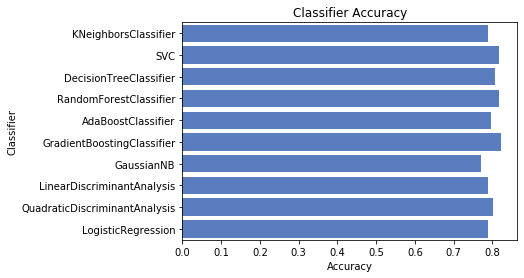

In [29]:
'''
https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
'''

import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True, gamma='auto'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='liblinear')]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

acc_dict = {}

for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

## Deep model

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, AveragePooling2D, Dropout
from keras.models import load_model

In [ ]:
def MyModel_v1():
    features = Input(shape=(nfeatures, ), dtype='float32')
    X = Dense(128, activation='relu')(features)
    X = Dense(64, activation='relu')(X)
    X = Dense(48, activation='relu')(X)
    X = Dense(36, activation='relu')(X)    
    X = Dense(24, activation='relu')(X)    
    X = Dense(1, activation='sigmoid', kernel_initializer='random_normal')(X)
    model = Model(inputs=features, outputs=X)
    return model

In [ ]:
del model

In [ ]:
model = MyModel_v1()
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X, Y, epochs=20, batch_size=8, validation_split=0.1)

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

In [ ]:
loss, acc = model.evaluate(X_test, Y_test)
print("Test loss = ", loss)
print("Test accuracy = ", acc)

## Submission

In [22]:
sub_test = pd.read_csv('kg-data/test.csv', sep=',')
sub_test.shape

(418, 11)

In [23]:
sub_test[0:10]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [24]:
preprocess_dataset(sub_test)

In [25]:
X_sub_test, df = extract_features(sub_test, pred=True)
df[0:10]

,Pclass,Sex,CategoricalAge,CategoricalFare,Embarked,IsAlone,Title
0,3,1,1,0,2,1,1
1,3,0,2,0,0,0,3
2,2,1,1,1,2,1,1
3,3,1,2,1,0,1,1
4,3,0,2,1,0,0,3
5,3,1,1,1,0,1,1
6,3,0,3,0,2,1,2
7,2,1,0,2,0,0,1
8,3,0,1,0,1,1,3
9,3,1,0,2,0,0,1


In [26]:
Y_sub_pred = model.predict(X_sub_test)

In [ ]:
# keras
Y_sub_pred = model.predict(X_sub_test).flatten()
Y_sub_pred = (Y_sub_pred > 0.5).astype(int)

In [27]:
ids = sub_test['PassengerId']
labels = pd.Series(Y_sub_pred, name="Survived")
submission = pd.concat([ids, labels], axis=1)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [28]:
submission.to_csv('kg-data/submission.csv', sep=',', index=False)

## Kaggle

In [ ]:
!kaggle competitions download -c titanic -p 'kg-data'

In [ ]:
!kaggle competitions submit -c titanic -f 'kg-data/submission.csv' -m 'FC model, 6 hidden layers'